# Training a Neural Net

In [ ]:
import os
import sys
import numpy
import math
import caffe

from pprint import pprint
from pylab import *
%matplotlib inline

# helper to show images in square
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    for im in data:
        pass
        #im -= im.min()
        #im /= im.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    if data.ndim == 4:
        plt.imshow(data)
    else:
        plt.imshow(data, cmap='gray')
        

libdc1394 error: Failed to initialize libdc1394
Drawing net to temp/net.png


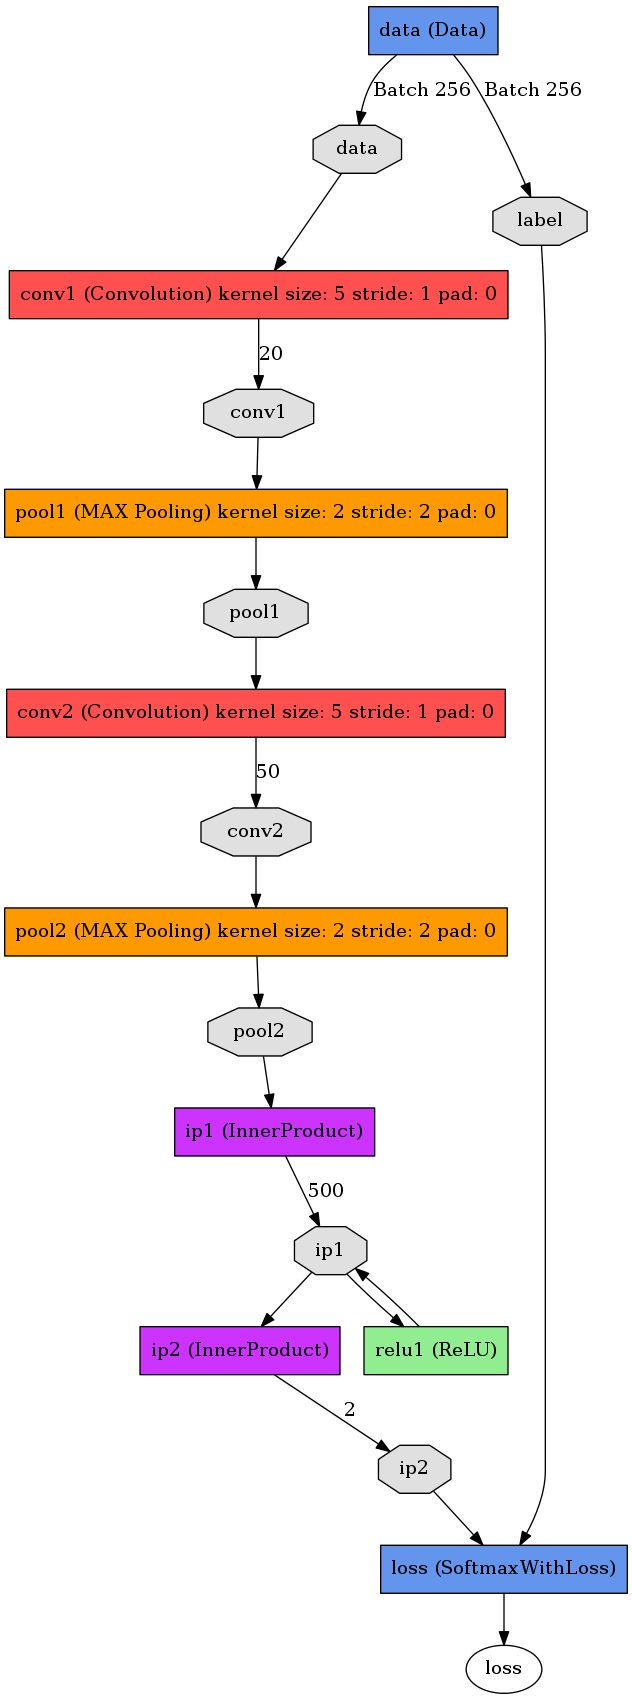

In [76]:
## Set up the network
from caffe import layers as L
from caffe import params as P

def lenet(lmdb, batch_size):
    # our version of LeNet: a series of linear and simple nonlinear transformations
    n = caffe.NetSpec()
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param={
                                'scale': 1./255,
                                'mean_file': 'temp/learnsat_mean.binaryproto'
                            }, ntop=2)
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.ip1 = L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.ip1, in_place=True)
    n.ip2 = L.InnerProduct(n.relu1, num_output=2, weight_filler=dict(type='xavier'))
    n.loss = L.SoftmaxWithLoss(n.ip2, n.label)
    return n.to_proto()
    


with open('temp/lenet_auto_train.prototxt', 'w') as f:
    f.write('name: "LeNet"\n')
    f.write(str(lenet('temp/learnsat_train_lmdb', 256)))
    
with open('temp/lenet_auto_test.prototxt', 'w') as f:
    f.write(str(lenet('temp/learnsat_val_lmdb', 100)))
    
# now draw the network!
!../caffe/python/draw_net.py --rankdir TB temp/lenet_auto_train.prototxt temp/net.png
from IPython.display import Image
Image(filename='temp/net.png')

In [74]:
solver_config = """# Generated from python.
# Train Set
# Size: 11997
# Batch: 256
# Epoch = 47 iterations
#
# Test Set
# Size: 3290
# Batch: 100
# Epoch = 33 iterations
#
# Training net
train_net: "temp/lenet_auto_train.prototxt"
# Test net
test_net: "temp/lenet_auto_test.prototxt"
test_iter: 33
# Run testing every ___ iterations:
test_interval: 100
# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.01
momentum: 0.9
weight_decay: 0.01
# The learning rate policy
lr_policy: "step"
gamma: 0.5
# ~ 5 epochs rule of thumb from Karpathy
stepsize: 235
# Display every 1/100 epoch
display: 100
# The maximum number of iterations
max_iter: 10000
# snapshot intermediate results
snapshot: 5000
snapshot_prefix: "snap/lenet"
# solver mode: CPU or GPU
solver_mode: GPU"""

with open('temp/autosolver.prototxt', 'w') as f:
    f.write(solver_config)

caffe.set_device(0)
caffe.set_mode_gpu()
solver = caffe.SGDSolver('temp/autosolver.prototxt')

# To get an idea of the architecture of our net, we can check the dimensions of 
# the intermediate features (blobs) and parameters (these will also be useful to 
# refer to when manipulating data later).

# each output is (batch size, feature dim, spatial dim)
pprint([(k, v.data.shape) for k, v in solver.net.blobs.items()])

# just print the weight sizes (not biases)
pprint([(k, v[0].data.shape) for k, v in solver.net.params.items()])

Before taking off, let's check that everything is loaded as we expect. We'll run a forward pass on the train and test nets and check that they contain our data.

In [18]:
solver.net.forward()  # train net
solver.test_nets[0].forward()  # test net (there can be more than one)

{'loss': array(0.6889512538909912, dtype=float32)}

In [6]:
# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': solver.net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load('temp/learnsat_mean.npy').mean(1).mean(1)) # mean pixel
#transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB


(16, 3, 128, 128)
[ 0.  0.  1.  0.  0.  0.  0.  1.  1.  0.  1.  0.  1.  0.  0.  0.]


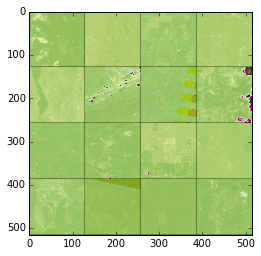

In [19]:
images = solver.net.blobs['data'].data[:16]
print(images.shape)
images = numpy.array([transformer.deprocess('data', i) for i in images])

vis_square(images)
print solver.net.blobs['label'].data[:16]

[ 0.  0.  0.  0.  1.  1.  0.  1.  0.  0.  1.  1.  1.  1.  0.  0.]


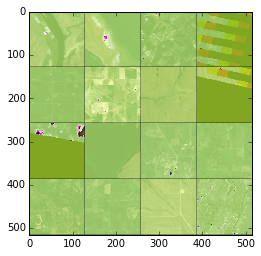

In [20]:
images = solver.test_nets[0].blobs['data'].data[:16]
images = numpy.array([transformer.deprocess('data', i) for i in images])
vis_square(images)
print solver.test_nets[0].blobs['label'].data[:16]

Both train and test nets seem to be loading data, and to have correct labels.

Let's take one step of (minibatch) SGD and see what happens.

In [21]:
solver.step(1)

Do we have gradients propagating through our filters? Let's see the updates to the first layer, shown here as a $4 \times 5$ grid of $5 \times 5$ filters.

(20, 5, 5)


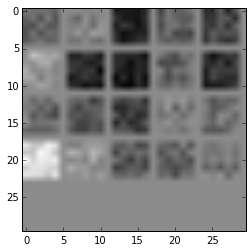

In [54]:
print(solver.net.params['conv1'][0].diff[:, 0].shape)
vis_square(solver.net.params['conv1'][0].diff[:, 0])


Something is happening. Let's run the net for a while, keeping track of a few things as it goes.
Note that this process will be the same as if training through the `caffe` binary. In particular:
* logging will continue to happen as normal
* snapshots will be taken at the interval specified in the solver prototxt (here, every 5000 iterations)
* testing will happen at the interval specified (here, every 500 iterations)

Since we have control of the loop in Python, we're free to compute additional things as we go, as we show below. We can do many other things as well, for example:
* write a custom stopping criterion
* change the solving process by updating the net in the loop

In [47]:
%%time
niter = 800
test_interval = 50
# losses will also be stored in the log
train_loss = zeros(niter)
train_acc = zeros(int(np.ceil(niter / test_interval)))
test_acc = zeros(int(np.ceil(niter / test_interval)))
output = zeros((niter, 16, 2))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1')
    output[it] = solver.test_nets[0].blobs['ip2'].data[:16]
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        total = 0
        for test_it in range(33):
            solver.test_nets[0].forward()
            total += len(solver.test_nets[0].blobs['ip2'].data)
            correct += sum(solver.test_nets[0].blobs['ip2'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = float(correct) / (total)
        correct = 0
        total = 0
        for test_it in range(47):
            solver.net.forward()
            total += len(solver.net.blobs['ip2'].data)
            correct += sum(solver.net.blobs['ip2'].data.argmax(1)
                           == solver.net.blobs['label'].data)
        train_acc[it // test_interval] = float(correct) / total

        

Iteration 0 testing...
Iteration 50 testing...
Iteration 100 testing...
Iteration 150 testing...
Iteration 200 testing...
Iteration 250 testing...
Iteration 300 testing...
Iteration 350 testing...
Iteration 400 testing...
Iteration 450 testing...
Iteration 500 testing...
Iteration 550 testing...
Iteration 600 testing...
Iteration 650 testing...
Iteration 700 testing...
Iteration 750 testing...
CPU times: user 8min 52s, sys: 3min 29s, total: 12min 21s
Wall time: 10min 45s


Let's plot the train loss and test accuracy.

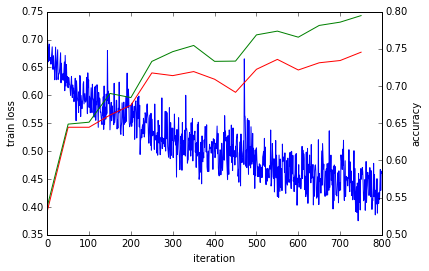

In [48]:
fig, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r',
         test_interval * arange(len(train_acc)), train_acc, 'g')
#ax3 = ax2.twinx()
#ax3.plot(test_interval * arange(len(test_acc)), train_acc, 'g')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('accuracy')
#ax3.set_ylabel('test accuracy')

In [49]:
results_file = 'results/lenet.lr01.wd01'
if os.path.exists(results_file + '_train_loss.npy'):
    print('File exists! NOT saving!')
else:
    numpy.save(results_file + '_train_loss.npy', train_loss)
    numpy.save(results_file + '_train_acc.npy', train_acc)
    numpy.save(results_file + '_test_acc.npy', test_acc)
    fig.savefig(results_file + '_plot.png')

Since we saved the results on the first test batch, we can watch how our prediction scores evolved. We'll plot time on the $x$ axis and each possible label on the $y$, with lightness indicating confidence.

[[[-0.00600671  0.02750786]
  [ 0.00246698  0.04396836]
  [-0.04161559  0.02796719]
  ..., 
  [ 0.0094124   0.00986209]
  [ 0.00462063  0.12873796]
  [-0.06888845  0.2094443 ]]

 [[-0.03181286 -0.04730088]
  [-0.01795901  0.00994262]
  [-0.02290912  0.03336907]
  ..., 
  [ 0.04470946 -0.26078802]
  [-0.01984206  0.00268071]
  [-0.05055036 -0.00396911]]

 [[-0.03058973 -0.04804515]
  [ 0.00196942 -0.00928864]
  [-0.02356889  0.03428199]
  ..., 
  [ 0.1378482  -0.34335354]
  [-0.00918368 -0.00783251]
  [-0.04299789 -0.01015104]]

 ..., 
 [[ 0.1404431  -0.09270362]
  [-0.81824905  0.56199884]
  [ 0.65335226 -0.61294341]
  ..., 
  [ 0.5692904  -0.58639705]
  [ 0.08397941  0.25780538]
  [-0.29906422  0.20039281]]

 [[ 0.15648827 -0.10458955]
  [-0.81778675  0.56693614]
  [ 0.56517088 -0.52498978]
  ..., 
  [ 0.42175418 -0.43751237]
  [ 0.15042618  0.19402593]
  [-0.28705907  0.19349569]]

 [[ 0.18472493 -0.12685204]
  [-0.75704783  0.51246905]
  [ 0.51720929 -0.47611064]
  ..., 
  [ 0.34608

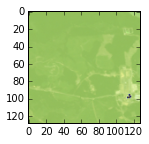

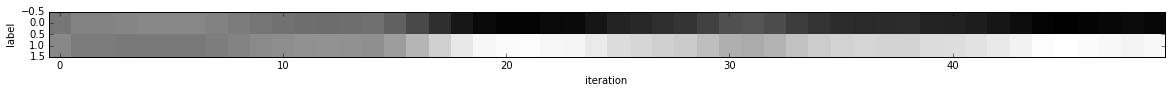

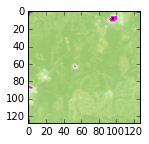

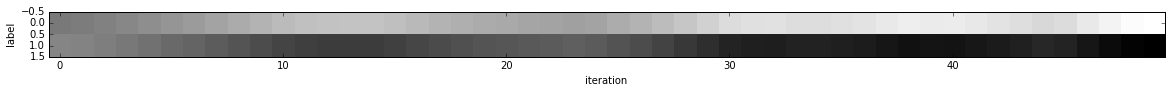

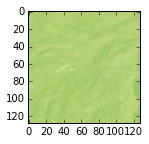

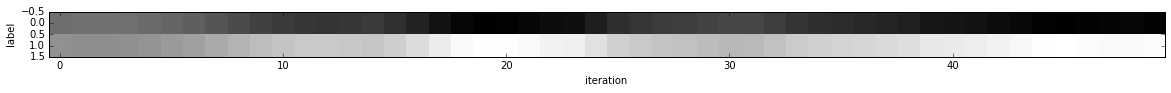

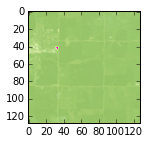

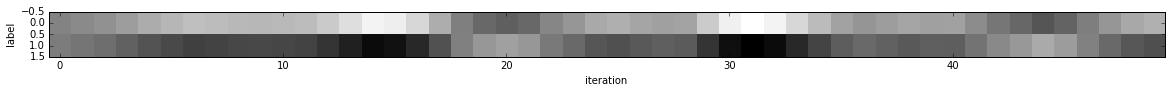

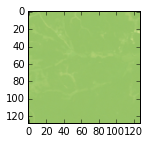

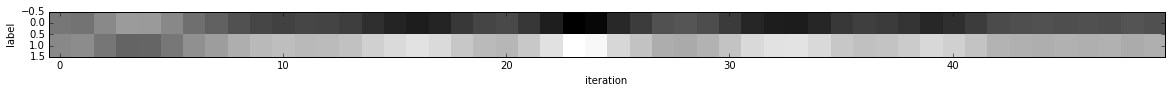

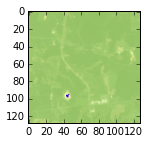

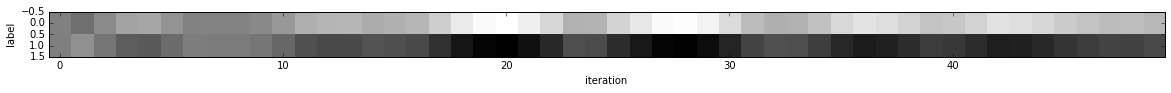

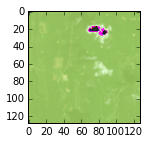

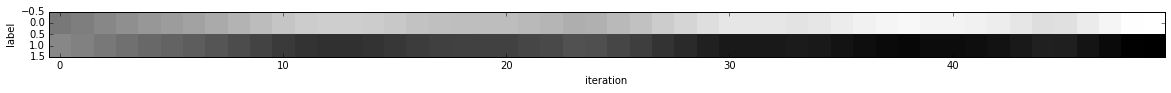

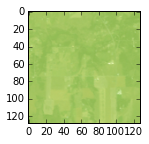

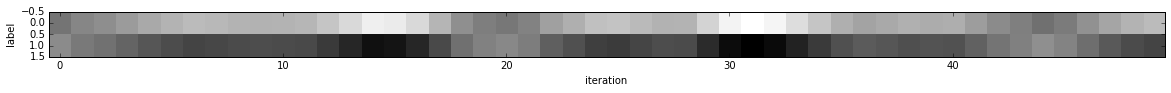

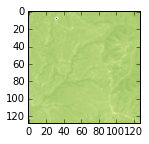

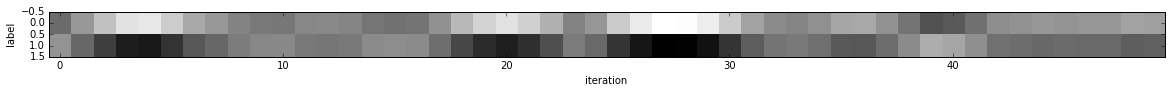

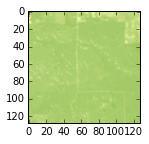

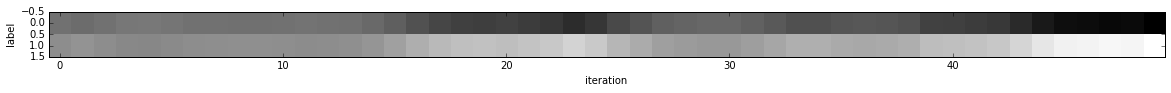

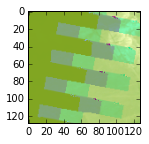

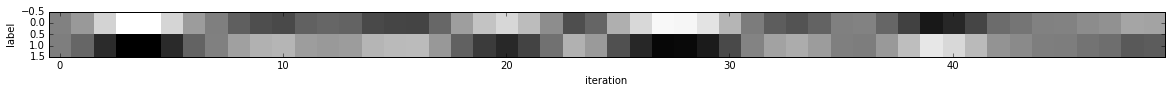

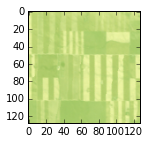

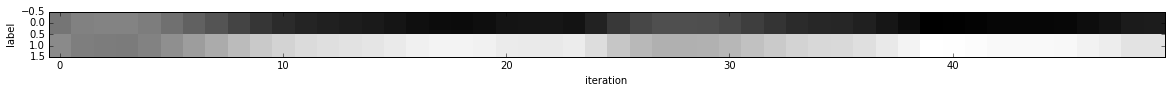

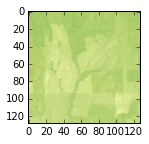

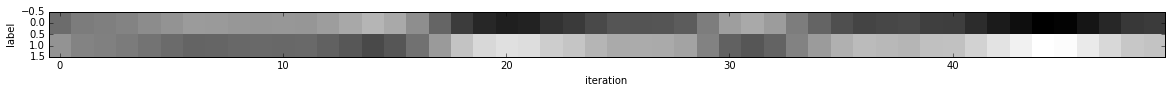

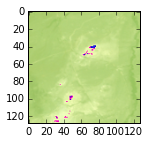

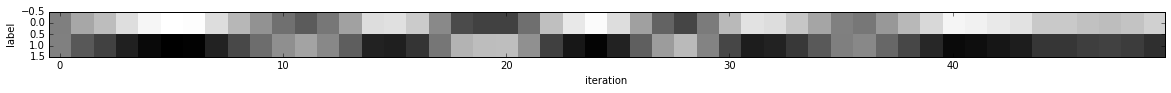

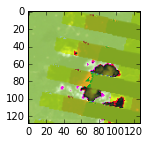

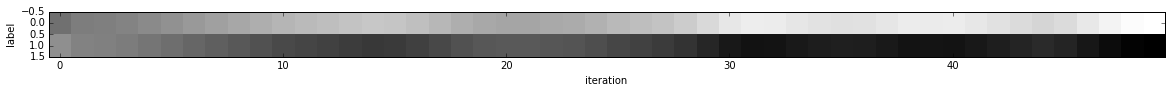

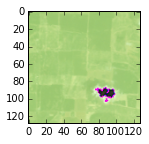

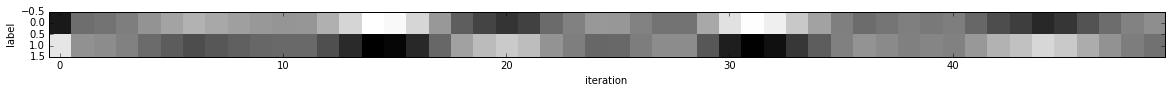

In [55]:
for i in range(16):
    figure(figsize=(2, 2))
    imshow(transformer.deprocess('data', solver.test_nets[0].blobs['data'].data[i]))
    figure(figsize=(20, 2))
    #imshow(output[:50, i].T, interpolation='nearest', cmap='gray')
    imshow(exp(output[:50, i].T) / exp(output[:50, i].T).sum(0), interpolation='nearest', cmap='gray')
    xlabel('iteration')
    ylabel('label')